# Préparation Data Set (3h)

## Information

Task
1. Build a forecast model for consumption in France: predict on day N at noon the total consumption of day N+1.

## Analyse Data Set

Overview and factors having an influence on elec consu

Ajouter : 
- Vacances / Weekend / Jour fériée / Soldes?
- "Période Froide" : sub 0 
- Attention Crise Covid : grosse influence (sous projection) sur la conso
- Jour Tempo -> Adaptation de la population pour diminuer naturrelement

Remarque 1 : Impossible de prendre en compte les Annuels Définitfs car anté covid et pendnat covid : influecne trop forte sur
la consommation réelle

Donnée Météo : https://www.data.gouv.fr/fr/datasets/donnees-de-temperature-et-de-pseudo-rayonnement-en-j-2/

## Importation

In [5]:
#Générique Importation
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

from vacances_scolaires_france import SchoolHolidayDates
import datetime

from lineartree           import LinearBoostRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

%load_ext autoreload
%autoreload 2

In [2]:
# Data Import
## Puissance
EnCours_Consolide = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-Consolide.csv",delimiter=";")
EnCours_Temps_R = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-TR.csv",delimiter=";")
Temp_Dep = pd.read_csv("data/temperature-quotidienne-departementale.csv",delimiter=";")
Temp_Nationale = pd.read_csv("data/donnees-de-temperature-et-de-pseudo-rayonnement.csv",delimiter=";")

Tempo_RTE_2122 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2021-2022.csv",delimiter=";")
Tempo_RTE_2223 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2022-2023.csv",delimiter=";")
Tempo_RTE_2324 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2023-2024.csv",delimiter=";")


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_9642/704178923.py:3: DtypeWarning: Columns (36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  EnCours_Consolide = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-Consolide.csv",delimiter=";")
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_9642/704178923.py:4: DtypeWarning: Columns (5,26,27,30,31,33,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  EnCours_Temps_R = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-TR.csv",delimiter=";")


## Présentation Des Fichiers

In [4]:
production = ['Fioul', 'Charbon', 'Gaz', 'Nucléaire',
       'Eolien', 'Solaire', 'Hydraulique', 'Pompage', 'Bioénergies',
       'Ech. physiques', 'Taux de Co2', 'Ech. comm. Angleterre',
       'Ech. comm. Espagne', 'Ech. comm. Italie', 'Ech. comm. Suisse',
       'Ech. comm. Allemagne-Belgique', 'Fioul - TAC', 'Fioul - Cogén.',
       'Fioul - Autres', 'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG',
       'Gaz - Autres', 'Hydraulique - Fil de l?eau + éclusée',
       'Hydraulique - Lacs', 'Hydraulique - STEP turbinage',
       'Bioénergies - Déchets', 'Bioénergies - Biomasse',
       'Bioénergies - Biogaz']

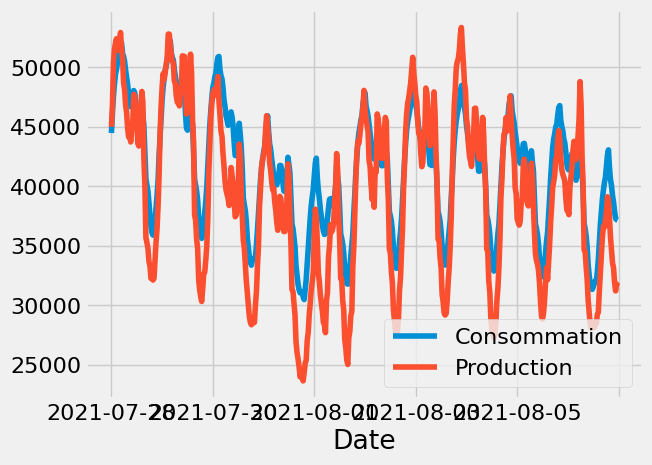

In [5]:
EnCours_Consolide['Production'] = EnCours_Consolide[production].sum(axis=1)
EnCours_Consolide[['Date','Heures','Consommation','Production']].dropna().set_index('Date')[10000:10500].plot();

## Cleaning DataBase  (A packager)

### Consommation France Consolidé 2021-01-01 -> 2022-05-31

In [6]:
#Supp dernière ligne
EnCours_Consolide.tail()
EnCours_Consolide.drop(EnCours_Consolide.tail(1).index,inplace = True)
EnCours_Consolide.tail()

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,...,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,Unnamed: 40,Production
49531,France,Données consolidées,2022-05-31,22:45,NaN,45950.0,46550.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ND,ND,NaN,NaN,NaN,0.0
49532,France,Données consolidées,2022-05-31,23:00,46703.0,47100.0,47600.0,81.0,3.0,3933.0,...,2046.0,492.0,393.0,332.0,ND,ND,ND,ND,NaN,62326.0
49533,France,Données consolidées,2022-05-31,23:15,NaN,46750.0,47250.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ND,ND,NaN,NaN,NaN,0.0
49534,France,Données consolidées,2022-05-31,23:30,45279.0,46400.0,46900.0,82.0,2.0,3748.0,...,1826.0,498.0,396.0,333.0,ND,ND,ND,ND,NaN,59694.0
49535,France,Données consolidées,2022-05-31,23:45,NaN,45600.0,45850.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ND,ND,NaN,NaN,NaN,0.0


In [7]:
EnCours_Consolide.head()

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,...,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,Unnamed: 40,Production
0,France,Données consolidées,2021-01-01,00:00,67010.0,67000.0,66800.0,94.0,7.0,5553.0,...,988.0,512.0,286.0,314.0,NaN,NaN,NaN,NaN,NaN,82494.0
1,France,Données consolidées,2021-01-01,00:15,NaN,66500.0,66300.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,France,Données consolidées,2021-01-01,00:30,67071.0,66000.0,65800.0,97.0,7.0,5637.0,...,1021.0,521.0,296.0,331.0,NaN,NaN,NaN,NaN,NaN,82702.0
3,France,Données consolidées,2021-01-01,00:45,NaN,65150.0,64900.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,France,Données consolidées,2021-01-01,01:00,65052.0,64300.0,64000.0,97.0,7.0,4515.0,...,469.0,520.0,296.0,331.0,NaN,NaN,NaN,NaN,NaN,78619.0


In [8]:
colum_keep = ['Périmètre','Date', 'Heures','Consommation']
EnCours_Consolide.columns

Index(['Périmètre', 'Nature', 'Date', 'Heures', 'Consommation',
       'Prévision J-1', 'Prévision J', 'Fioul', 'Charbon', 'Gaz', 'Nucléaire',
       'Eolien', 'Solaire', 'Hydraulique', 'Pompage', 'Bioénergies',
       'Ech. physiques', 'Taux de Co2', 'Ech. comm. Angleterre',
       'Ech. comm. Espagne', 'Ech. comm. Italie', 'Ech. comm. Suisse',
       'Ech. comm. Allemagne-Belgique', 'Fioul - TAC', 'Fioul - Cogén.',
       'Fioul - Autres', 'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG',
       'Gaz - Autres', 'Hydraulique - Fil de l?eau + éclusée',
       'Hydraulique - Lacs', 'Hydraulique - STEP turbinage',
       'Bioénergies - Déchets', 'Bioénergies - Biomasse',
       'Bioénergies - Biogaz', ' Stockage batterie', 'Déstockage batterie',
       'Eolien terrestre', 'Eolien offshore', 'Unnamed: 40', 'Production'],
      dtype='object')

In [9]:
conso_consolidee = EnCours_Consolide[colum_keep]
conso_consolidee.head()

,Périmètre,Date,Heures,Consommation
0,France,2021-01-01,00:00,67010.0
1,France,2021-01-01,00:15,NaN
2,France,2021-01-01,00:30,67071.0
3,France,2021-01-01,00:45,NaN
4,France,2021-01-01,01:00,65052.0


In [10]:
conso_consolidee.dtypes

Périmètre        object
Date             object
Heures           object
Consommation    float64
dtype: object

In [11]:
conso_consolidee['date_hour'] = pd.to_datetime(conso_consolidee['Date']+ " "+ conso_consolidee['Heures'])

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/2950347574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_consolidee['date_hour'] = pd.to_datetime(conso_consolidee['Date']+ " "+ conso_consolidee['Heures'])


In [12]:
conso_consolidee.dtypes
conso_consolidee.drop(columns='Heures',inplace=True)
conso_consolidee.drop(columns='Date',inplace=True)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/1252045613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_consolidee.drop(columns='Heures',inplace=True)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/1252045613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_consolidee.drop(columns='Date',inplace=True)


In [13]:
conso_consolidee.dtypes

Périmètre               object
Consommation           float64
date_hour       datetime64[ns]
dtype: object

Lors de la consolidation seule les données consolidées et définitives (options 3 et 4) sont fournies au pas demi-heure

In [14]:
conso_consolidee.shape

(49536, 3)

In [15]:
consom_final_consol = conso_consolidee.dropna()
consom_final_consol

,Périmètre,Consommation,date_hour
0,France,67010.0,2021-01-01 00:00:00
2,France,67071.0,2021-01-01 00:30:00
4,France,65052.0,2021-01-01 01:00:00
6,France,64918.0,2021-01-01 01:30:00
8,France,64376.0,2021-01-01 02:00:00
...,...,...,...
49526,France,44043.0,2022-05-31 21:30:00
49528,France,44019.0,2022-05-31 22:00:00
49530,France,45067.0,2022-05-31 22:30:00
49532,France,46703.0,2022-05-31 23:00:00


### Consommation France TReel 2022-06-01 -> 2024-01-18 

In [16]:
#Supp dernière ligne
EnCours_Temps_R.tail()
EnCours_Temps_R.drop(EnCours_Temps_R.tail(1).index,inplace = True)
EnCours_Temps_R.tail()

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,...,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,Unnamed: 40
57499,France,Données temps réel,2024-01-20,22:45,NaN,ND,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57500,France,Données temps réel,2024-01-20,23:00,NaN,ND,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57501,France,Données temps réel,2024-01-20,23:15,NaN,ND,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57502,France,Données temps réel,2024-01-20,23:30,NaN,ND,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57503,France,Données temps réel,2024-01-20,23:45,NaN,ND,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
EnCours_Temps_R.head()

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,...,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,Unnamed: 40
0,France,Données temps réel,2022-06-01,00:00,44940.0,44800,45100.0,144.0,0.0,3596.0,...,1054,1677.0,170,584.0,286.0,ND,ND,ND,ND,NaN
1,France,Données temps réel,2022-06-01,00:15,43967.0,43700,43900.0,144.0,0.0,3716.0,...,1419,581.0,171,560.0,276.0,ND,ND,ND,ND,NaN
2,France,Données temps réel,2022-06-01,00:30,42514.0,42600,42700.0,142.0,0.0,2880.0,...,1280,530.0,169,561.0,276.0,ND,ND,ND,ND,NaN
3,France,Données temps réel,2022-06-01,00:45,41073.0,41450,41600.0,143.0,0.0,2699.0,...,1120,361.0,170,563.0,276.0,ND,ND,ND,ND,NaN
4,France,Données temps réel,2022-06-01,01:00,40359.0,40300,40500.0,144.0,3.0,2718.0,...,1101,373.0,170,563.0,276.0,ND,ND,ND,ND,NaN


In [18]:
colum_keep = ['Périmètre','Date', 'Heures','Consommation']
EnCours_Temps_R.columns

Index(['Périmètre', 'Nature', 'Date', 'Heures', 'Consommation',
       'Prévision J-1', 'Prévision J', 'Fioul', 'Charbon', 'Gaz', 'Nucléaire',
       'Eolien', 'Solaire', 'Hydraulique', 'Pompage', 'Bioénergies',
       'Ech. physiques', 'Taux de Co2', 'Ech. comm. Angleterre',
       'Ech. comm. Espagne', 'Ech. comm. Italie', 'Ech. comm. Suisse',
       'Ech. comm. Allemagne-Belgique', 'Fioul - TAC', 'Fioul - Cogén.',
       'Fioul - Autres', 'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG',
       'Gaz - Autres', 'Hydraulique - Fil de l?eau + éclusée',
       'Hydraulique - Lacs', 'Hydraulique - STEP turbinage',
       'Bioénergies - Déchets', 'Bioénergies - Biomasse',
       'Bioénergies - Biogaz', ' Stockage batterie', 'Déstockage batterie',
       'Eolien terrestre', 'Eolien offshore', 'Unnamed: 40'],
      dtype='object')

In [19]:
conso_TR = EnCours_Temps_R[colum_keep]
conso_TR.head()

,Périmètre,Date,Heures,Consommation
0,France,2022-06-01,00:00,44940.0
1,France,2022-06-01,00:15,43967.0
2,France,2022-06-01,00:30,42514.0
3,France,2022-06-01,00:45,41073.0
4,France,2022-06-01,01:00,40359.0


In [20]:
conso_TR.dtypes

Périmètre        object
Date             object
Heures           object
Consommation    float64
dtype: object

In [21]:
conso_TR['date_hour'] = pd.to_datetime(conso_TR['Date']+ " "+ conso_TR['Heures'])

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/2548613233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_TR['date_hour'] = pd.to_datetime(conso_TR['Date']+ " "+ conso_TR['Heures'])


In [22]:
conso_TR.dtypes
conso_TR.drop(columns='Heures',inplace=True)
conso_TR.drop(columns='Date',inplace=True)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/2243417616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_TR.drop(columns='Heures',inplace=True)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/2243417616.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_TR.drop(columns='Date',inplace=True)


In [23]:
conso_TR.dtypes

Périmètre               object
Consommation           float64
date_hour       datetime64[ns]
dtype: object

Lors de la consolidation seule les données consolidées et définitives (options 3 et 4) sont fournies au pas demi-heure

In [24]:
conso_TR.shape

(57504, 3)

In [25]:
conso_TR.isna().sum()

Périmètre         0
Consommation    225
date_hour         0
dtype: int64

In [26]:
conso_final_TR = conso_TR.dropna()
conso_final_TR

,Périmètre,Consommation,date_hour
0,France,44940.0,2022-06-01 00:00:00
1,France,43967.0,2022-06-01 00:15:00
2,France,42514.0,2022-06-01 00:30:00
3,France,41073.0,2022-06-01 00:45:00
4,France,40359.0,2022-06-01 01:00:00
...,...,...,...
57274,France,67663.0,2024-01-18 14:30:00
57275,France,68208.0,2024-01-18 14:45:00
57276,France,67868.0,2024-01-18 15:00:00
57277,France,67745.0,2024-01-18 15:15:00


### Température Département ## Pas Ouf ##

In [27]:
Temp_Dep #Pas assez précis pour un modèle efficace car le pas est de l'autre de la journée
#Premier jet avec

,date_obs,code_insee_departement,departement,tmin,tmax,tmoy
0,2019-10-22,21,Côte-d'Or,10.90,16.00,13.45
1,2019-10-22,73,Savoie,11.70,18.65,15.18
2,2019-10-22,29,Finistère,7.77,15.48,11.63
3,2019-10-22,48,Lozère,9.70,16.50,13.10
4,2019-10-22,49,Maine-et-Loire,4.40,15.10,9.75
...,...,...,...,...,...,...
210331,2023-12-31,87,Haute-Vienne,5.00,8.70,6.85
210332,2023-12-31,91,Essonne,7.60,10.80,9.20
210333,2023-12-31,70,Haute-Saône,4.30,12.40,8.35
210334,2023-12-31,60,Oise,7.97,10.23,9.10


In [28]:
Temp_Dep.groupby(by='date_obs').mean() #Moyenne de la TMin max et moy sur l'ensemble France par jour

,tmin,tmax,tmoy
date_obs,,,
2018-01-01,5.844167,10.404167,8.124167
2018-01-02,5.530938,13.406562,9.468750
2018-01-03,7.651667,13.897708,10.774688
2018-01-04,8.257604,14.363125,11.315625
2018-01-05,7.670417,12.787083,10.228854
...,...,...,...
2023-12-27,3.017292,12.384167,7.701146
2023-12-28,5.818542,11.503542,8.661250
2023-12-29,7.130625,12.395729,9.763125


### Température National #Zero Na identifié

In [29]:
Temp_Nationale.dtypes

horodate                                                        object
temperature_realisee_lissee_degc                               float64
temperature_normale_lissee_degc                                float64
temperature_realisee_lissee_temperature_normale_lissee_degc    float64
pseudo_rayonnement                                             float64
annee                                                            int64
mois                                                             int64
jour                                                             int64
annee_mois_jour                                                 object
dtype: object

In [30]:
Temp_Nationale.head()

,horodate,temperature_realisee_lissee_degc,temperature_normale_lissee_degc,temperature_realisee_lissee_temperature_normale_lissee_degc,pseudo_rayonnement,annee,mois,jour,annee_mois_jour
0,2024-01-17T20:00:00+00:00,4.8,4.9,-0.1,28.0,2024,1,17,2024-01-17
1,2024-01-17T14:30:00+00:00,5.8,6.0,-0.2,8.0,2024,1,17,2024-01-17
2,2024-01-17T12:30:00+00:00,5.4,5.8,-0.4,4.0,2024,1,17,2024-01-17
3,2024-01-17T12:00:00+00:00,5.4,5.7,-0.3,3.0,2024,1,17,2024-01-17
4,2024-01-17T08:30:00+00:00,3.7,4.5,-0.8,11.0,2024,1,17,2024-01-17


In [31]:
colum_temp = ['horodate', 'temperature_realisee_lissee_degc','annee', 'mois', 'jour', 'annee_mois_jour']
Temp_Nationale.columns

Index(['horodate', 'temperature_realisee_lissee_degc',
       'temperature_normale_lissee_degc',
       'temperature_realisee_lissee_temperature_normale_lissee_degc',
       'pseudo_rayonnement', 'annee', 'mois', 'jour', 'annee_mois_jour'],
      dtype='object')

In [32]:
Temp_Nationale_final = Temp_Nationale[colum_temp]
Temp_Nationale_final

,horodate,temperature_realisee_lissee_degc,annee,mois,jour,annee_mois_jour
0,2024-01-17T20:00:00+00:00,4.8,2024,1,17,2024-01-17
1,2024-01-17T14:30:00+00:00,5.8,2024,1,17,2024-01-17
2,2024-01-17T12:30:00+00:00,5.4,2024,1,17,2024-01-17
3,2024-01-17T12:00:00+00:00,5.4,2024,1,17,2024-01-17
4,2024-01-17T08:30:00+00:00,3.7,2024,1,17,2024-01-17
...,...,...,...,...,...,...
87643,2019-01-19T06:00:00+00:00,3.1,2019,1,19,2019-01-19
87644,2019-01-19T01:30:00+00:00,3.5,2019,1,19,2019-01-19
87645,2019-01-18T05:00:00+00:00,4.7,2019,1,18,2019-01-18
87646,2019-01-18T02:30:00+00:00,5.1,2019,1,18,2019-01-18


In [33]:
Temp_Nationale_final['horodate'] = Temp_Nationale_final['horodate'].map(lambda x : x[:-6])
Temp_Nationale_final['horodate'] = pd.to_datetime(Temp_Nationale_final['horodate'],utc=False)
Temp_Nationale_final

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/3118806497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temp_Nationale_final['horodate'] = Temp_Nationale_final['horodate'].map(lambda x : x[:-6])
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/3118806497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temp_Nationale_final['horodate'] = pd.to_datetime(Temp_Nationale_final['horodate'],utc=False)


,horodate,temperature_realisee_lissee_degc,annee,mois,jour,annee_mois_jour
0,2024-01-17 20:00:00,4.8,2024,1,17,2024-01-17
1,2024-01-17 14:30:00,5.8,2024,1,17,2024-01-17
2,2024-01-17 12:30:00,5.4,2024,1,17,2024-01-17
3,2024-01-17 12:00:00,5.4,2024,1,17,2024-01-17
4,2024-01-17 08:30:00,3.7,2024,1,17,2024-01-17
...,...,...,...,...,...,...
87643,2019-01-19 06:00:00,3.1,2019,1,19,2019-01-19
87644,2019-01-19 01:30:00,3.5,2019,1,19,2019-01-19
87645,2019-01-18 05:00:00,4.7,2019,1,18,2019-01-18
87646,2019-01-18 02:30:00,5.1,2019,1,18,2019-01-18


In [34]:
Temp_Nationale_final.drop(columns='annee_mois_jour',inplace=True)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/901101941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temp_Nationale_final.drop(columns='annee_mois_jour',inplace=True)


In [35]:
Temp_Nationale_final = Temp_Nationale_final.sort_values(by='horodate')
Temp_Nationale_final

,horodate,temperature_realisee_lissee_degc,annee,mois,jour
76660,2019-01-17 23:00:00,5.3,2019,1,17
87647,2019-01-17 23:30:00,5.3,2019,1,17
43837,2019-01-18 00:00:00,5.3,2019,1,18
43836,2019-01-18 00:30:00,5.2,2019,1,18
76659,2019-01-18 01:00:00,5.2,2019,1,18
...,...,...,...,...,...
35472,2024-01-17 20:30:00,4.8,2024,1,17
35471,2024-01-17 21:00:00,4.8,2024,1,17
12131,2024-01-17 21:30:00,4.8,2024,1,17
35470,2024-01-17 22:00:00,4.8,2024,1,17


## Ajout d'autres Dataframe

### WeekDay

In [36]:
conso_final_TR['weekday'] = conso_final_TR['date_hour'].map(lambda x : x.weekday())
conso_final_TR

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/2984687522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_final_TR['weekday'] = conso_final_TR['date_hour'].map(lambda x : x.weekday())


,Périmètre,Consommation,date_hour,weekday
0,France,44940.0,2022-06-01 00:00:00,2
1,France,43967.0,2022-06-01 00:15:00,2
2,France,42514.0,2022-06-01 00:30:00,2
3,France,41073.0,2022-06-01 00:45:00,2
4,France,40359.0,2022-06-01 01:00:00,2
...,...,...,...,...
57274,France,67663.0,2024-01-18 14:30:00,3
57275,France,68208.0,2024-01-18 14:45:00,3
57276,France,67868.0,2024-01-18 15:00:00,3
57277,France,67745.0,2024-01-18 15:15:00,3


In [37]:
consom_final_consol['weekday'] = consom_final_consol['date_hour'].map(lambda x : x.weekday())
consom_final_consol

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/1222613907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consom_final_consol['weekday'] = consom_final_consol['date_hour'].map(lambda x : x.weekday())


,Périmètre,Consommation,date_hour,weekday
0,France,67010.0,2021-01-01 00:00:00,4
2,France,67071.0,2021-01-01 00:30:00,4
4,France,65052.0,2021-01-01 01:00:00,4
6,France,64918.0,2021-01-01 01:30:00,4
8,France,64376.0,2021-01-01 02:00:00,4
...,...,...,...,...
49526,France,44043.0,2022-05-31 21:30:00,1
49528,France,44019.0,2022-05-31 22:00:00,1
49530,France,45067.0,2022-05-31 22:30:00,1
49532,France,46703.0,2022-05-31 23:00:00,1


### Température

In [38]:
Temp_Nationale_final

,horodate,temperature_realisee_lissee_degc,annee,mois,jour
76660,2019-01-17 23:00:00,5.3,2019,1,17
87647,2019-01-17 23:30:00,5.3,2019,1,17
43837,2019-01-18 00:00:00,5.3,2019,1,18
43836,2019-01-18 00:30:00,5.2,2019,1,18
76659,2019-01-18 01:00:00,5.2,2019,1,18
...,...,...,...,...,...
35472,2024-01-17 20:30:00,4.8,2024,1,17
35471,2024-01-17 21:00:00,4.8,2024,1,17
12131,2024-01-17 21:30:00,4.8,2024,1,17
35470,2024-01-17 22:00:00,4.8,2024,1,17


### Vacance Scolaire

In [39]:
d = SchoolHolidayDates()
conso_final_TR['school_holiday'] = conso_final_TR['date_hour'].map(lambda x : 1 if d.is_holiday(x.date()) else 0)
consom_final_consol['school_holiday'] = consom_final_consol['date_hour'].map(lambda x : 1 if d.is_holiday(x.date()) else 0)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/936875408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_final_TR['school_holiday'] = conso_final_TR['date_hour'].map(lambda x : 1 if d.is_holiday(x.date()) else 0)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/936875408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consom_final_consol['school_holiday'] = consom_final_consol['date_hour'].map(lambda x : 1 if d.is_holiday(x.date()) else 0)


### Jours Fériés

In [40]:
from jours_feries_france import JoursFeries

In [41]:
res_total = {}
for annee in range(2021,2025):
    res = JoursFeries.for_year(annee)
    res_total.update({f"{cle} {annee}": date for cle, date in res.items()})
#print(res_total)

In [42]:
conso_final_TR['public_holiday'] = conso_final_TR['date_hour'].map(lambda x : 1 if (x.date() in res_total.values()) else 0)
consom_final_consol['public_holiday'] = consom_final_consol['date_hour'].map(lambda x : 1 if (x.date() in res_total.values()) else 0)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/3960669137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_final_TR['public_holiday'] = conso_final_TR['date_hour'].map(lambda x : 1 if (x.date() in res_total.values()) else 0)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/3960669137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consom_final_consol['public_holiday'] = consom_final_consol['date_hour'].map(lambda x : 1 if (x.date() in res_total.values()) else 0

In [43]:
#conso_final_TR[(conso_final_TR['date_hour']>'2023-12-23 00:00:00')&(conso_final_TR['date_hour']<'2023-12-26 00:00:00')]

### TEMPO

In [78]:
Tempo_RTE_2122

#Supp dernière ligne
Tempo_RTE_2122.tail()
Tempo_RTE_2122.drop(Tempo_RTE_2122.tail(1).index,inplace = True)
Tempo_RTE_2122.tail()

,Date,Type de jour TEMPO
360,2022-08-27,BLEU
361,2022-08-28,BLEU
362,2022-08-29,BLEU
363,2022-08-30,BLEU
364,2022-08-31,BLEU


In [79]:
Tempo_RTE_2223

#Supp dernière ligne
Tempo_RTE_2223.tail()
Tempo_RTE_2223.drop(Tempo_RTE_2223.tail(1).index,inplace = True)
Tempo_RTE_2223.tail()

,Date,Type de jour TEMPO
360,2023-08-27,BLEU
361,2023-08-28,BLEU
362,2023-08-29,BLEU
363,2023-08-30,BLEU
364,2023-08-31,BLEU


In [80]:
Tempo_RTE_2324

#Supp dernière ligne
Tempo_RTE_2324.tail()
Tempo_RTE_2324.drop(Tempo_RTE_2324.tail(1).index,inplace = True)
Tempo_RTE_2324.tail()

,Date,Type de jour TEMPO
136,2024-01-15,ROUGE
137,2024-01-16,ROUGE
138,2024-01-17,BLANC
139,2024-01-18,ROUGE
140,2024-01-19,ROUGE


In [81]:
Tempo_RTE_2122['Date'] = pd.to_datetime(Tempo_RTE_2122['Date'], format="%Y-%m-%d")
Tempo_RTE_2223['Date'] = pd.to_datetime(Tempo_RTE_2223['Date'], format="%Y-%m-%d")
Tempo_RTE_2324['Date'] = pd.to_datetime(Tempo_RTE_2324['Date'], format="%Y-%m-%d")

### Merge Finale

In [44]:
conso_final_TR

,Périmètre,Consommation,date_hour,weekday,school_holiday,public_holiday
0,France,44940.0,2022-06-01 00:00:00,2,0,0
1,France,43967.0,2022-06-01 00:15:00,2,0,0
2,France,42514.0,2022-06-01 00:30:00,2,0,0
3,France,41073.0,2022-06-01 00:45:00,2,0,0
4,France,40359.0,2022-06-01 01:00:00,2,0,0
...,...,...,...,...,...,...
57274,France,67663.0,2024-01-18 14:30:00,3,0,0
57275,France,68208.0,2024-01-18 14:45:00,3,0,0
57276,France,67868.0,2024-01-18 15:00:00,3,0,0
57277,France,67745.0,2024-01-18 15:15:00,3,0,0


In [45]:
consom_final_consol

,Périmètre,Consommation,date_hour,weekday,school_holiday,public_holiday
0,France,67010.0,2021-01-01 00:00:00,4,1,1
2,France,67071.0,2021-01-01 00:30:00,4,1,1
4,France,65052.0,2021-01-01 01:00:00,4,1,1
6,France,64918.0,2021-01-01 01:30:00,4,1,1
8,France,64376.0,2021-01-01 02:00:00,4,1,1
...,...,...,...,...,...,...
49526,France,44043.0,2022-05-31 21:30:00,1,0,0
49528,France,44019.0,2022-05-31 22:00:00,1,0,0
49530,France,45067.0,2022-05-31 22:30:00,1,0,0
49532,France,46703.0,2022-05-31 23:00:00,1,0,0


In [46]:
Temp_Nationale_final.columns = ['date_hour', 'temperature_realisee_lissee_degc', 'annee', 'mois',
       'jour']
Temp_Nationale_final

,date_hour,temperature_realisee_lissee_degc,annee,mois,jour
76660,2019-01-17 23:00:00,5.3,2019,1,17
87647,2019-01-17 23:30:00,5.3,2019,1,17
43837,2019-01-18 00:00:00,5.3,2019,1,18
43836,2019-01-18 00:30:00,5.2,2019,1,18
76659,2019-01-18 01:00:00,5.2,2019,1,18
...,...,...,...,...,...
35472,2024-01-17 20:30:00,4.8,2024,1,17
35471,2024-01-17 21:00:00,4.8,2024,1,17
12131,2024-01-17 21:30:00,4.8,2024,1,17
35470,2024-01-17 22:00:00,4.8,2024,1,17


In [47]:
conso_final_TR_merged = conso_final_TR.merge(Temp_Nationale_final,how='inner',on="date_hour")
conso_final_TR_merged

,Périmètre,Consommation,date_hour,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour
0,France,44940.0,2022-06-01 00:00:00,2,0,0,15.9,2022,6,1
1,France,42514.0,2022-06-01 00:30:00,2,0,0,15.9,2022,6,1
2,France,40359.0,2022-06-01 01:00:00,2,0,0,15.8,2022,6,1
3,France,40049.0,2022-06-01 01:30:00,2,0,0,15.8,2022,6,1
4,France,39328.0,2022-06-01 02:00:00,2,0,0,15.7,2022,6,1
...,...,...,...,...,...,...,...,...,...,...
28601,France,67515.0,2024-01-17 20:30:00,2,0,0,4.8,2024,1,17
28602,France,65217.0,2024-01-17 21:00:00,2,0,0,4.8,2024,1,17
28603,France,63881.0,2024-01-17 21:30:00,2,0,0,4.8,2024,1,17
28604,France,62791.0,2024-01-17 22:00:00,2,0,0,4.8,2024,1,17


In [48]:
consom_final_consol_merged = consom_final_consol.merge(Temp_Nationale_final,how='inner',on="date_hour")
consom_final_consol_merged

,Périmètre,Consommation,date_hour,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour
0,France,67010.0,2021-01-01 00:00:00,4,1,1,3.9,2021,1,1
1,France,67071.0,2021-01-01 00:30:00,4,1,1,3.9,2021,1,1
2,France,65052.0,2021-01-01 01:00:00,4,1,1,3.8,2021,1,1
3,France,64918.0,2021-01-01 01:30:00,4,1,1,3.8,2021,1,1
4,France,64376.0,2021-01-01 02:00:00,4,1,1,3.8,2021,1,1
...,...,...,...,...,...,...,...,...,...,...
24763,France,44043.0,2022-05-31 21:30:00,1,0,0,16.2,2022,5,31
24764,France,44019.0,2022-05-31 22:00:00,1,0,0,16.2,2022,5,31
24765,France,45067.0,2022-05-31 22:30:00,1,0,0,16.1,2022,5,31
24766,France,46703.0,2022-05-31 23:00:00,1,0,0,16.0,2022,5,31


In [85]:
# Merged Colonne Tempo
consom_final_consol_merged['Date'] = consom_final_consol_merged['date_hour'].map(lambda x : x.date())
consom_final_consol_merged

,Périmètre,Consommation,date_hour,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour,Date
0,France,67010.0,2021-01-01 00:00:00,4,1,1,3.9,2021,1,1,2021-01-01
1,France,67071.0,2021-01-01 00:30:00,4,1,1,3.9,2021,1,1,2021-01-01
2,France,65052.0,2021-01-01 01:00:00,4,1,1,3.8,2021,1,1,2021-01-01
3,France,64918.0,2021-01-01 01:30:00,4,1,1,3.8,2021,1,1,2021-01-01
4,France,64376.0,2021-01-01 02:00:00,4,1,1,3.8,2021,1,1,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...
24763,France,44043.0,2022-05-31 21:30:00,1,0,0,16.2,2022,5,31,2022-05-31
24764,France,44019.0,2022-05-31 22:00:00,1,0,0,16.2,2022,5,31,2022-05-31
24765,France,45067.0,2022-05-31 22:30:00,1,0,0,16.1,2022,5,31,2022-05-31
24766,France,46703.0,2022-05-31 23:00:00,1,0,0,16.0,2022,5,31,2022-05-31


# Création ML (1h30) - Sans TEMPO

In [49]:
conso_final_TR_merged.head()

,Périmètre,Consommation,date_hour,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour
0,France,44940.0,2022-06-01 00:00:00,2,0,0,15.9,2022,6,1
1,France,42514.0,2022-06-01 00:30:00,2,0,0,15.9,2022,6,1
2,France,40359.0,2022-06-01 01:00:00,2,0,0,15.8,2022,6,1
3,France,40049.0,2022-06-01 01:30:00,2,0,0,15.8,2022,6,1
4,France,39328.0,2022-06-01 02:00:00,2,0,0,15.7,2022,6,1


In [50]:
conso_final_TR_merged = conso_final_TR_merged[['annee', 'mois',
       'jour','date_hour','Périmètre',  'weekday', 'school_holiday',
       'public_holiday', 'temperature_realisee_lissee_degc','Consommation' ]].drop(columns='Périmètre')
conso_final_TR_merged

,annee,mois,jour,date_hour,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,Consommation
0,2022,6,1,2022-06-01 00:00:00,2,0,0,15.9,44940.0
1,2022,6,1,2022-06-01 00:30:00,2,0,0,15.9,42514.0
2,2022,6,1,2022-06-01 01:00:00,2,0,0,15.8,40359.0
3,2022,6,1,2022-06-01 01:30:00,2,0,0,15.8,40049.0
4,2022,6,1,2022-06-01 02:00:00,2,0,0,15.7,39328.0
...,...,...,...,...,...,...,...,...,...
28601,2024,1,17,2024-01-17 20:30:00,2,0,0,4.8,67515.0
28602,2024,1,17,2024-01-17 21:00:00,2,0,0,4.8,65217.0
28603,2024,1,17,2024-01-17 21:30:00,2,0,0,4.8,63881.0
28604,2024,1,17,2024-01-17 22:00:00,2,0,0,4.8,62791.0


In [51]:
conso_final_TR_merged.head()

,annee,mois,jour,date_hour,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,Consommation
0,2022,6,1,2022-06-01 00:00:00,2,0,0,15.9,44940.0
1,2022,6,1,2022-06-01 00:30:00,2,0,0,15.9,42514.0
2,2022,6,1,2022-06-01 01:00:00,2,0,0,15.8,40359.0
3,2022,6,1,2022-06-01 01:30:00,2,0,0,15.8,40049.0
4,2022,6,1,2022-06-01 02:00:00,2,0,0,15.7,39328.0


In [52]:
conso_final_TR_merged['hour'] = conso_final_TR_merged['date_hour'].map(lambda x: x.hour)
conso_final_TR_merged['minute'] = conso_final_TR_merged['date_hour'].map(lambda x: x.minute)
conso_final_TR_merged.drop(columns='date_hour',inplace=True)
conso_final_TR_merged

,annee,mois,jour,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,Consommation,hour,minute
0,2022,6,1,2,0,0,15.9,44940.0,0,0
1,2022,6,1,2,0,0,15.9,42514.0,0,30
2,2022,6,1,2,0,0,15.8,40359.0,1,0
3,2022,6,1,2,0,0,15.8,40049.0,1,30
4,2022,6,1,2,0,0,15.7,39328.0,2,0
...,...,...,...,...,...,...,...,...,...,...
28601,2024,1,17,2,0,0,4.8,67515.0,20,30
28602,2024,1,17,2,0,0,4.8,65217.0,21,0
28603,2024,1,17,2,0,0,4.8,63881.0,21,30
28604,2024,1,17,2,0,0,4.8,62791.0,22,0


In [64]:
n = conso_final_TR_merged.shape[0]

train = conso_final_TR_merged.iloc[:int(n*0.9985)]
test = conso_final_TR_merged.iloc[int(n*0.9985):]

print(train.shape,test.shape)

(28563, 10) (43, 10)


In [65]:
X_train = train.drop(columns='Consommation')
y_train = train.Consommation

X_test = test.drop(columns='Consommation')
y_test = test.Consommation

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(28563, 9) (43, 9) (28563,) (43,)


## Sans Sclaing avec HistGradientBoostingRegressor

In [66]:
from sklearn.ensemble import HistGradientBoostingRegressor

regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train, y_train)

test["predictions"] = regressor.predict(X_test)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_66815/3216738537.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = regressor.predict(X_test)


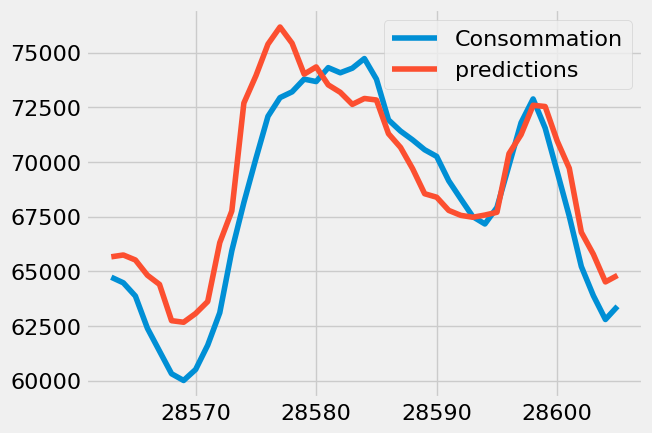

In [67]:
test[['Consommation','predictions']].plot();

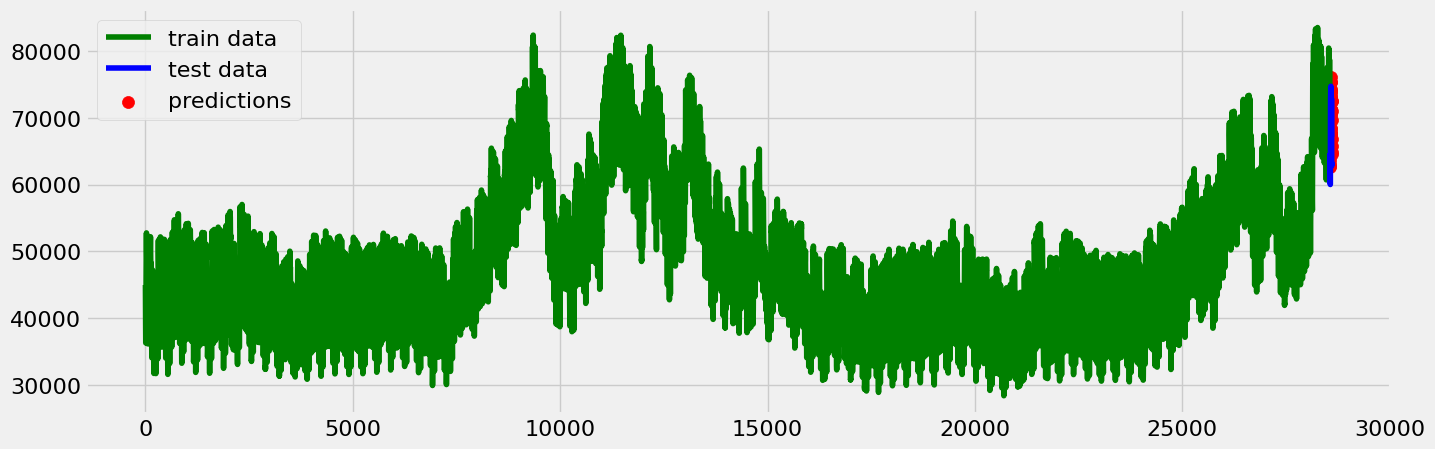

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.index,train["Consommation"], label='train data', color="green")
ax.plot(test.index,test["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [69]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions"]))

MSE = 3.721e+06
MSE = 0.02429


Conlusion :
    - Bon modèle dans notre cas car le maximum situé au milie de la courbe lui donne une "référence" de cette zone de consommation. Dans le cas ou il n irait pas aussi haut, la courbe est restreinte au maximum qu'il a rencontré dans le train (exemple ci dessous)

#### Exemple Train trop faible

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_56154/1599888288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_less_data"] = regressor.predict(X_test)


<AxesSubplot:>

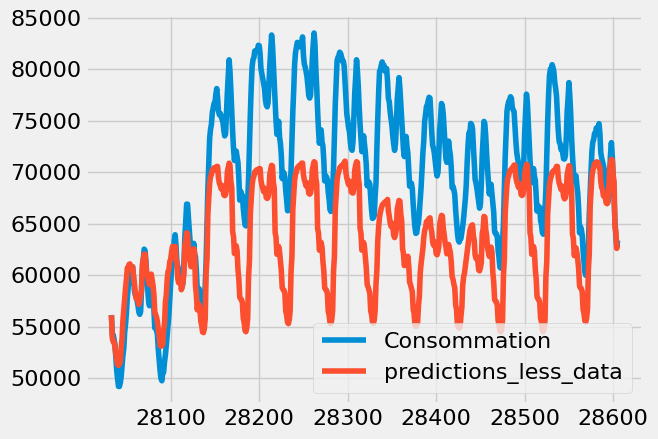

In [58]:
regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train[20000:], y_train[20000:])

test["predictions_less_data"] = regressor.predict(X_test)
test[['Consommation','predictions_less_data']].plot()

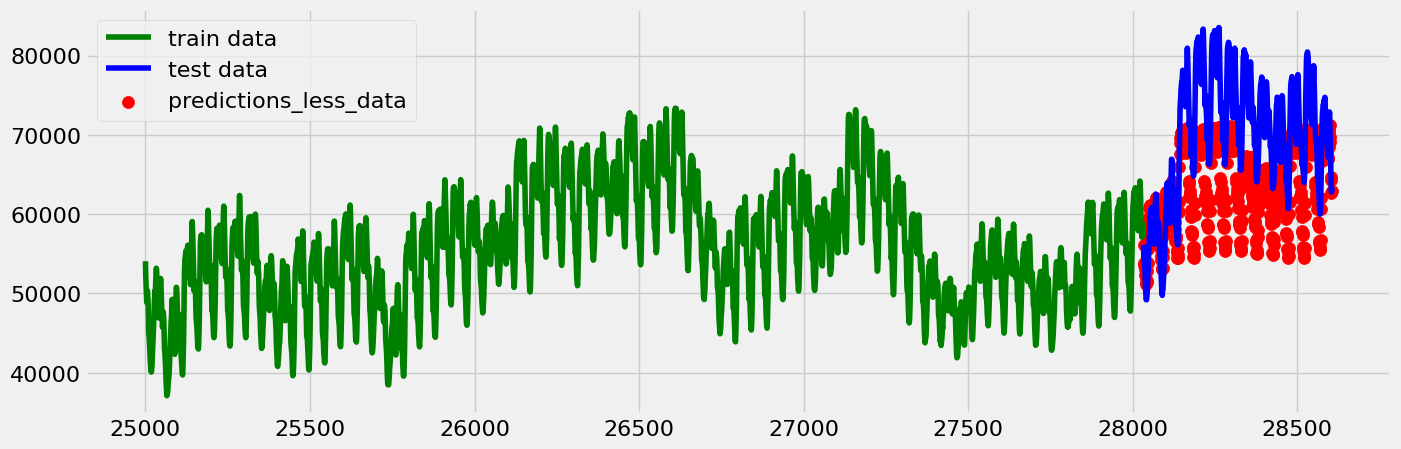

In [59]:
train_zoom = train[25000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_less_data"], label='predictions_less_data', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [60]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_less_data"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_less_data"]))

MSE = 6.417e+07
MSE = 0.09761


## Sans Scaling avec LinearBoostRegressor

https://github.com/cerlymarco/linear-tree

In [61]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 300,
                                 max_depth    = 5,
                                 random_state = 42)

regressor.fit(X_train, y_train)
test["predictions_Linear"] = regressor.predict(X_test)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_56154/2935177586.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_Linear"] = regressor.predict(X_test)


<AxesSubplot:>

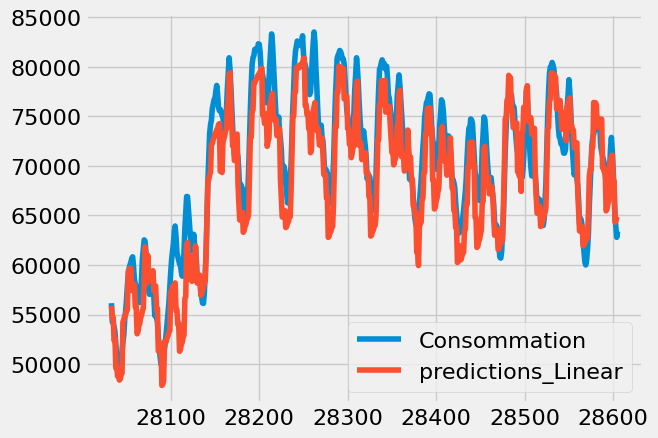

In [62]:
test[['Consommation','predictions_Linear']].plot()

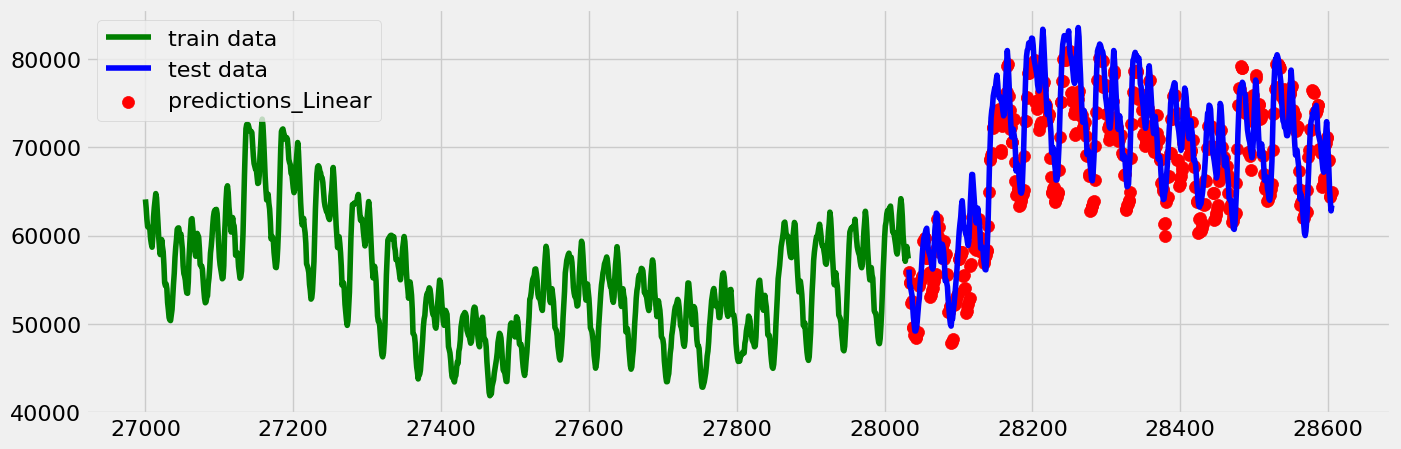

In [63]:
train_zoom = train[27000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_Linear"], label='predictions_Linear', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [64]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"]))

MSE = 8.807e+06
MSE = 0.03458


#### Exemple Train trop faible

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_56154/271266074.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_Linear_less_data"] = regressor.predict(X_test)


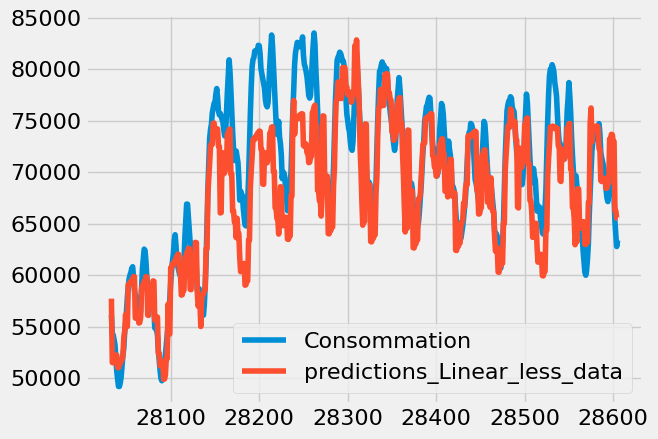

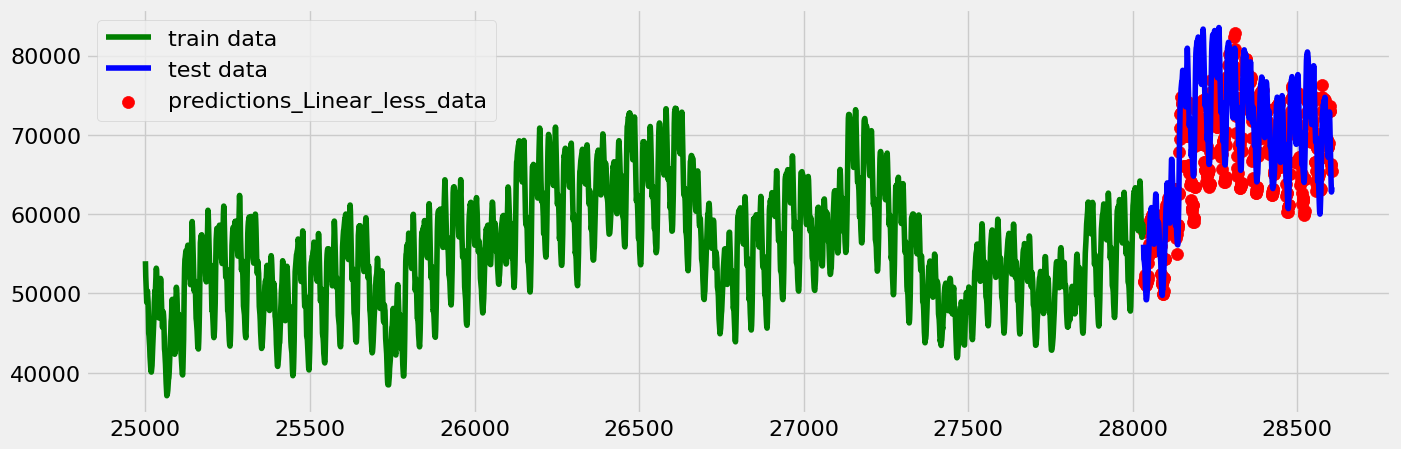

In [65]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 300,
                                 max_depth    = 5,
                                 random_state = 42)

regressor.fit(X_train[20000:], y_train[20000:])
test["predictions_Linear_less_data"] = regressor.predict(X_test)

test[['Consommation','predictions_Linear_less_data']].plot()
train_zoom = train[25000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_Linear_less_data"], label='predictions_Linear_less_data', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [66]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear_less_data"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear_less_data"]))

MSE = 1.482e+07
MSE = 0.04089


## Etape de Scaler/Création Pipeline - OK 

In [ ]:
#Ajouter dans le finale

## Autre modèles ? Pour l'instant pas nécessaire

In [ ]:
#Possible de passer par d'autres modèles ? AutoArima ? Prophète ? XGBoost ? LightGBM ?

# TEST

## Etape de critique des résultats : bizarre d'avoir un truc aussi beau ! Data Leak ? Tout bien pris en compte ?
## Analyse de la solution Linear Tree pour pas galère à expliquer
## Finalisation pour créer un modèle qui permet de prédire le jour d'après facilement ! - OK
## Ajouter le Tempo donné par RTE : influence de la consommartion (journée RBB) - OK 
## Effcetuer une matrice de corréla tion avec la matrice finale afin d'en dégager les colonnes importantes - OK
## Effectuer une colonne permutation afin de voir si efficace (même si pas beosin car pas trop de colonnes et pas nécessaire d'avoir à réduire la dimension) pas besoin
## Packager analyse data from RTE et from - OK
## request pour RTE date d'aujourd'hui (cf test pour le lendemain) REPONSE QUESTION - OK 